
<h1 style="text-align:center"><font size="4">Practice 1: Exploratory Data Analysis and Feature Extraction</font></h1>

<font size="4"><span style="font-weight:bold;"></span> Carlos Saico</font>


## Importing Libraries

In [5]:
from time import time
from datetime import datetime, timedelta
import pandas as pd  
import numpy as np  

import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
import seaborn
from sklearn import set_config        

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
#json:  {l1:'8',l2:'1'}
from sklearn.model_selection import train_test_split
from keras.models import load_model
print('Imported Modules')

Imported Modules


In [6]:
# Functions for saving and loading a Pipeline or Model
def guardarPipeline(pipeline, fileName):
    with open(fileName + '.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

def transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features, output):
    transformed_dataframe = copy.deepcopy(dataframe)
    totalVariables = len(transformed_dataframe.columns)
    print('Total variables before transformation: ', totalVariables)
    
    nominalVariablesCount = len(categorical_nominal_features)
    binaryVariablesCount = 0
    for variable in categorical_nominal_features:
        binaryVariablesCount += transformed_dataframe[variable].nunique()
    print('Number of binary variables: ', binaryVariablesCount)
    
    totalVariablesAfterTransformation = totalVariables - nominalVariablesCount + binaryVariablesCount
    print('Total variables after transformation: ', totalVariablesAfterTransformation)
    
    # Definition of transformers (preprocessors)
    # 1. Categorical to numerical transformer (ordinal and nominal)
    categorical_ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])
    
    categorical_nominal_transformer_with_names = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown="ignore"))  # ignore unknown category
    ])
    
    categorical_numeric_preprocessor_with_names = ColumnTransformer(
        transformers=[
            ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
            ('catnom', categorical_nominal_transformer_with_names, categorical_nominal_features)
        ],
        remainder='passthrough',
        n_jobs=-1
    )
    
    # 2. Normalization and scaling: numeric features with MinMaxScaler
    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(0, 1)))
    ])
    
    preprocessorMinMax = ColumnTransformer(transformers=[
        ('tranminmax', minmax_transformer, list(range(totalVariablesAfterTransformation)))
    ], remainder='passthrough')
    
    # 3. Standardization: numeric features with StandardScaler
    standardscaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True, with_std=True))
    ])
    
    preprocessorStandardScaler = ColumnTransformer(transformers=[
        ('transcaler', standardscaler_transformer, list(range(totalVariablesAfterTransformation)))
    ], remainder='passthrough')
    
    # Pipeline construction with transformers
    pipe = Pipeline(steps=[
        ('prepcn', categorical_numeric_preprocessor_with_names),
        #('prepstandard', preprocessorStandardScaler)
        ('prepminmax', preprocessorMinMax)
    ])
    
    # Apply variable transformation
    X_transformed = pipe.fit_transform(transformed_dataframe)
    print('********** Pipeline applied')
    guardarPipeline(pipe, 'pipePreprocessors')
    set_config(display='diagram')
    
    # Build transformed dataframe
    cnamesDataset1 = []
    if len(categorical_ordinal_features) != 0:
        cnamesDataset1.extend(categorical_ordinal_features)
    if len(categorical_nominal_features) != 0:
        cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
        cnamesDataset1.extend(cnamesDataset2)
    cnamesDataset3 = numeric_features
    cnamesDataset1.extend(cnamesDataset3)
    
    #print(cnamesDataset1)
    transformed_dataframe = pd.DataFrame(data=X_transformed, columns=cnamesDataset1)
    transformed_dataframe = pd.concat([transformed_dataframe, output], axis=1)
    
    return transformed_dataframe, pipe

def guardarModelo(pipeline, fileName):
    with open(fileName + '.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle saved")

def transformarPrediccion(lista):
    for i in range(len(lista)):
        performance = lista[i]
        #print(performance)
        if performance < 0:
            performance = 0
        elif performance > 1:
            performance = 1
        lista[i] = performance
    return lista

print("Functions defined")


Functions defined


<h1 style="text-align:center"><font size="4">Dataset Description</font></h1>


**Name:** Heart Disease <br>
**Link:** https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset<br>
**Description:** This dataset from 1988 contains medical information and health-related characteristics of patients and is used to predict whether a patient has heart disease or not, indicated in the output variable **target**. The variables include age, sex, blood cholesterol, etc.<br>
**Number of variables:** 13<br>
**Number of observations:** 1025<br>
**Output variable:** target (0 = not diseased, 1 = diseased)<br>

<span style="color:#FF5733; font-size:22px; font-weight:bold">Data Loading</span>


In [14]:

dfOriginal = pd.read_csv("C:/Users/carlo/OneDrive/Escritorio/ProyectosGit/Practica-1/heart.csv", sep=',')
print(dfOriginal.shape)
dfOriginal.head(10)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [15]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
Y=dataframe['target']
dataframe.head(10)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [16]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


As can be seen in our dataset, we have 13 variables plus the output variable. Additionally, all variables have 1,025 samples, meaning there are no missing data.

<span style="color:#FF5733; font-size:22px; font-weight:bold">Statistical Summary</span>


In [17]:
dataframe.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


According to the descriptive analysis, it can be determined:
- That the minimum age is **29**
- The mean age is **54.434146**
- The maximum age is **77**
- Regarding the minimum amount of cholesterol, it is **126.00000** and the maximum amount of cholesterol is **564.00000**


<span style="color:#FF5733; font-size:22px; font-weight:bold">DATA VISUALIZATION</span>


Healthy: 499
Sick: 526


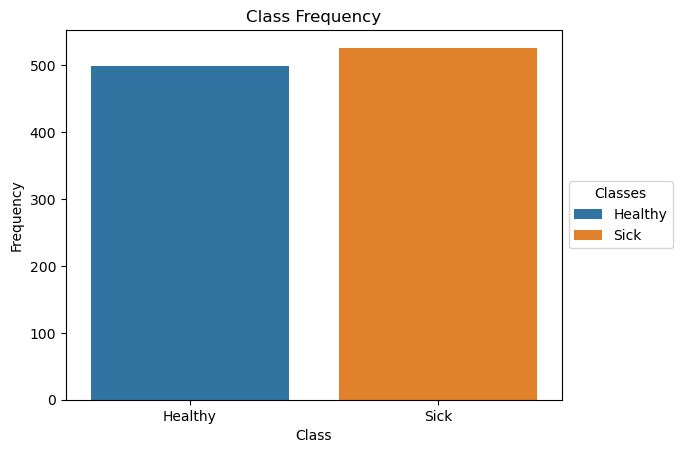

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Y = dataframe['target']

# Count the number of 0s and 1s in the 'Y' series
value_counts = Y.value_counts()

# Show the exact number of 0s and 1s
print("Healthy:", value_counts[0])
print("Sick:", value_counts[1])

# Generate the class frequency figure
sns.countplot(x='target', data=dataframe, hue='target')

# Labels for the axes
plt.xlabel('Class')
plt.ylabel('Frequency')

# Title of the plot
plt.title('Class Frequency')

# Define the labels for the plot bars
plt.xticks([0, 1], ['Healthy', 'Sick'])

# Place the legend (labels) on the right side
plt.legend(labels=['Healthy', 'Sick'], title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()


- According to the frequency plot, it can be observed that there is a higher presence of sick patients (**526**) than healthy ones (**499**)


In [19]:
#Sort the DataFrame by a variable
dataframeTratamiento=dataframe.sort_values(by=['age'])
dataframeTratamiento.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
60,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
118,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
668,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
64,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
572,34,1,3,118,182,0,0,174,0,0.0,2,0,2,1


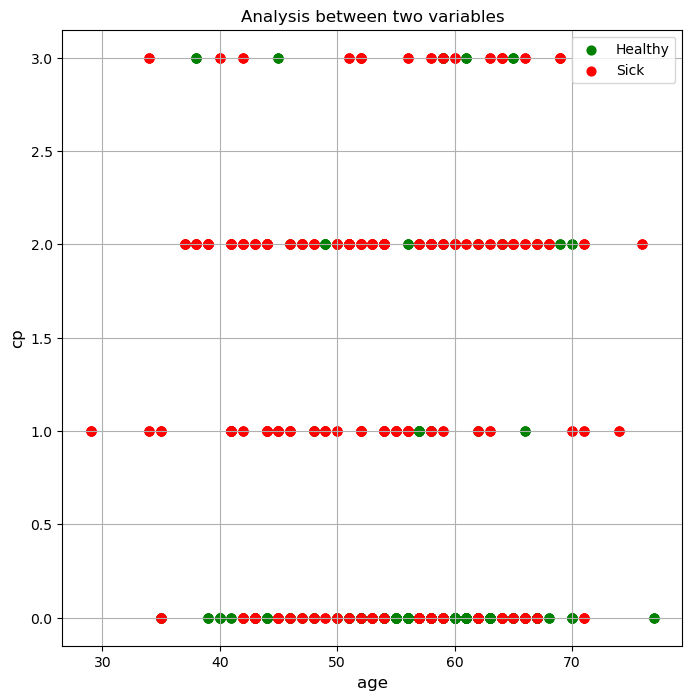

In [20]:
# 2D Visualization: multiple variables for analysis
import matplotlib.pyplot as plt
#plt.style.use('classic')
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('age', fontsize = 12)
ax.set_ylabel('cp', fontsize = 12)
ax.set_title('Analysis between two variables', fontsize = 12)
targets = [0, 1] # 0 healthy, 1 sick
colors = ['g', 'r']
for target, color in zip(targets, colors):
    indicesToKeep = dataframeTratamiento['target'] == target
    ax.scatter(dataframeTratamiento.loc[indicesToKeep, 'age']
               , dataframeTratamiento.loc[indicesToKeep, 'cp']
               , c = color
               , s = 40)
ax.legend(['Healthy','Sick'])
ax.grid()
plt.show()


- The correlation between these two variables suggests a trend or pattern in the occurrence of heart diseases with respect to age. In this case, it can be determined that both the variables age and cp are closely correlated with the presence of heart diseases. This means that heart diseases could be more common as people get older.


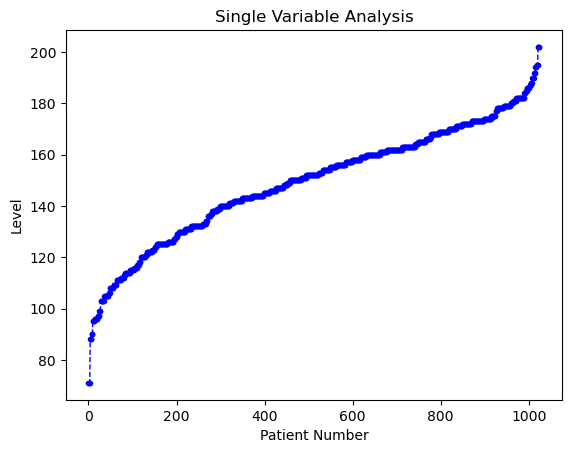

In [21]:
# 2D Visualization: single variable for analysis
#print(plt.style.available)
#plt.style.use('dark_background')
#plt.style.use('seaborn-darkgrid')

dataframeTratamientoOrdenado = dataframeTratamiento.sort_values(by=['thalach'])

variableAnalisis = dataframeTratamientoOrdenado.loc[:, ['thalach']]

cantidadMuestras = len(dataframeTratamientoOrdenado.index)
arrayCantidadMuestras = range(cantidadMuestras)

plt.plot(arrayCantidadMuestras, variableAnalisis, color='blue', linestyle='dashed', linewidth=1, 
         marker='o', markerfacecolor='blue', markersize=3)
#plt.ylim((0,35))
plt.title('Single Variable Analysis')
plt.xlabel('Patient Number')
plt.ylabel('Level')
plt.show()


- The plot shows a positive correlation between the number of observations and the value, which means that as the number of observations increases, the value does as well. This could indicate that as more data are collected (more observations), the value of the variable in question tends to increase.


<span style="color:#FF5733; font-size:22px; font-weight:bold">Categorical Variables Analysis</span>


In [22]:
def descripcionCantidadCategorias(dataframe, categorical_features):
    totalVariables = len(dataframe.columns) 
    totalCategoricalVariables = len(categorical_features)
    for variable in categorical_features:
        numCategories = dataframe[variable].nunique()
        print('Number of categories in variable', variable, ':', numCategories)
    return totalCategoricalVariables


In [27]:
categorical_features = ['cp',  'slope','sex', 'exang', 'thal','restecg', 'fbs']


In [28]:
categoricalVariablesCount = descripcionCantidadCategorias(dataframe, categorical_features)
print('Number of categorical variables:', categoricalVariablesCount)


Number of categories in variable cp : 4
Number of categories in variable slope : 3
Number of categories in variable sex : 2
Number of categories in variable exang : 2
Number of categories in variable thal : 4
Number of categories in variable restecg : 3
Number of categories in variable fbs : 2
Number of categorical variables: 7


- There are 2 ordinal categorical variables: **cp** and **slope**
- There are 5 nominal categorical variables: **sex**, **exang**, **thal**, **restecg**, and **fbs**


**cp:** type of chest pain

         - Value 1: typical angina
         - Value 2: atypical angina
         - Value 3: non-anginal pain
         - Value 4: asymptomatic
         
**slope:** the slope of the ST segment during peak exercise

         - Value 1: upsloping
         - Value 2: flat
         - Value 3: downsloping
         
**sex:** sex (1 = male; 0 = female)

**exang:** exercise-induced angina (1 = yes; 0 = no)

**thal:** 3 = normal; 6 = fixed defect; 7 = reversible defect

**restecg:** resting electrocardiographic results
         - Value 0: normal
         - Value 1: having ST-T wave abnormality
         - Value 2: probable or definite left ventricular hypertrophy according to Estes’ 20-point criteria
         
**fbs:** (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)


<span style="color:#FF5733; font-size:22px; font-weight:bold">Correlation Analysis</span>


In [29]:
# Analysis between two variables: x, y
x = np.array([5,5,1])
y = np.array([1,2,5])

# Covariance
covariance = np.cov(x, y, bias=True)[0][1]
# bias: False for (N - 1) if it is a sample, True for (N) if it is the entire population
print('Covariance:', covariance)

# Dictionary
dict = {'X': x,
        'Y': y}
# Create DataFrame from a dictionary
df = pd.DataFrame(dict)

# Standard deviation of a variable
std = df['Y'].std(ddof=0)
print('Standard deviation:', std)

# Correlations
df.corr()


Covariance: -3.111111111111111
Standard deviation: 1.699673171197595


,X,Y
X,1.000000,-0.970725
Y,-0.970725,1.000000


In [63]:
#Análisis entre tres variables: u1, u2, u3
u1 = np.array([5,1])
u2 = np.array([5,2])
u3 = np.array([1,5])

#Covarianza
covariance = np.cov(u2, u3, bias=True)[0][1]
#bias: False para (N - 1) si es una muestra, True para (N) si es toda la población
print('Covarianza:',covariance)

#Diccionario
dict = {'u1': u1,
        'u2': u2,
        'u3': u3}
 
#Creación de dataframe a partir de un diccionario
df = pd.DataFrame(dict)

#Desviación estándar de una variable
std=df['u3'].std(ddof=0)
print('Desviación estándar:',std)

#Correlaciones
df.corr()

Covarianza: -3.0
Desviación estándar: 2.0


,u1,u2,u3
u1,1.0,1.0,-1.0
u2,1.0,1.0,-1.0
u3,-1.0,-1.0,1.0


In [31]:
#Análisis entre todas las variables
cr=dataframe.corr(numeric_only = True)
cr.head(15)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.103240,-0.071966,0.271121,0.219823,0.121243,-0.132696,-0.390227,0.088163,0.208137,-0.169105,0.271551,0.072297,-0.229324
sex,-0.103240,1.000000,-0.041119,-0.078974,-0.198258,0.027200,-0.055117,-0.049365,0.139157,0.084687,-0.026666,0.111729,0.198424,-0.279501
cp,-0.071966,-0.041119,1.000000,0.038177,-0.081641,0.079294,0.043581,0.306839,-0.401513,-0.174733,0.131633,-0.176206,-0.163341,0.434854
trestbps,0.271121,-0.078974,0.038177,1.000000,0.127977,0.181767,-0.123794,-0.039264,0.061197,0.187434,-0.120445,0.104554,0.059276,-0.138772
chol,0.219823,-0.198258,-0.081641,0.127977,1.000000,0.026917,-0.147410,-0.021772,0.067382,0.064880,-0.014248,0.074259,0.100244,-0.099966
fbs,0.121243,0.027200,0.079294,0.181767,0.026917,1.000000,-0.104051,-0.008866,0.049261,0.010859,-0.061902,0.137156,-0.042177,-0.041164
restecg,-0.132696,-0.055117,0.043581,-0.123794,-0.147410,-0.104051,1.000000,0.048411,-0.065606,-0.050114,0.086086,-0.078072,-0.020504,0.134468
thalach,-0.390227,-0.049365,0.306839,-0.039264,-0.021772,-0.008866,0.048411,1.000000,-0.380281,-0.349796,0.395308,-0.207888,-0.098068,0.422895
exang,0.088163,0.139157,-0.401513,0.061197,0.067382,0.049261,-0.065606,-0.380281,1.000000,0.310844,-0.267335,0.107849,0.197201,-0.438029
oldpeak,0.208137,0.084687,-0.174733,0.187434,0.064880,0.010859,-0.050114,-0.349796,0.310844,1.000000,-0.575189,0.221816,0.202672,-0.438441


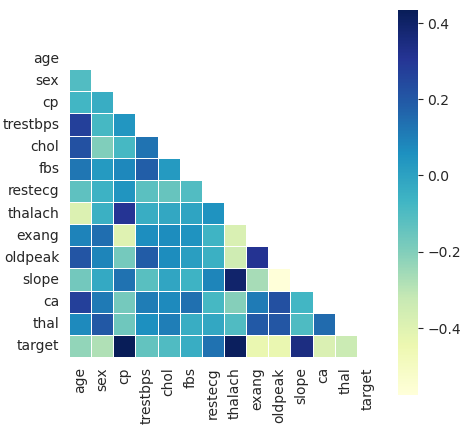

In [32]:
# A customized heatmap: colors, region below the diagonal, size
mask = np.zeros_like(cr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(cr, mask=mask, square=True, linewidths=.5, cmap="YlGnBu")
plt.savefig('attribute_correlations.png')


In [33]:
#Análisis a partir de los valores: correlaciones positivas
dfCorrOrdenado=cr.sort_values(by=['target'], ascending=False)
dfCorrOrdenado['target'].head(10)

target      1.000000
cp          0.434854
thalach     0.422895
slope       0.345512
restecg     0.134468
fbs        -0.041164
chol       -0.099966
trestbps   -0.138772
age        -0.229324
sex        -0.279501
Name: target, dtype: float64

The 3 variables most positively correlated are: **cp** (0.434854), **thalach** (0.422895), **slope** (0.345512)


In [67]:
#Análisis a partir de los valores: correlaciones negativas
dfCorrOrdenado=cr.sort_values(by=['target'], ascending=True)
dfCorrOrdenado['target'].head(10)

oldpeak    -0.438441
exang      -0.438029
ca         -0.382085
thal       -0.337838
sex        -0.279501
age        -0.229324
trestbps   -0.138772
chol       -0.099966
fbs        -0.041164
restecg     0.134468
Name: target, dtype: float64

The 3 variables most negatively correlated are: **oldpeak** (-0.438441), **exang** (-0.438029), **ca** (-0.382085)


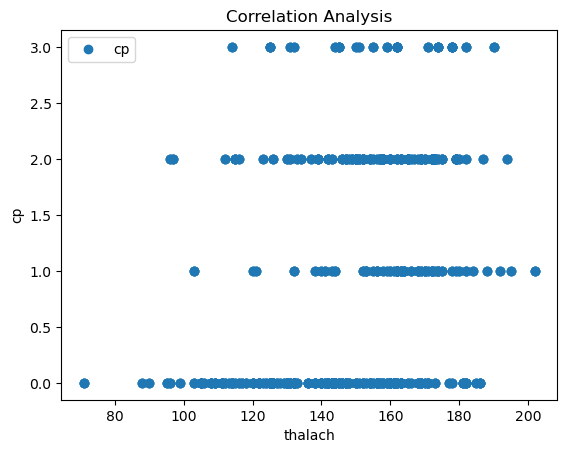

In [34]:
# Visualization for analysis between two variables
variable1Analisis = 'thalach'
variable2Analisis = 'cp'
dataframe.plot(x=variable1Analisis, y=variable2Analisis, style='o')  
plt.title('Correlation Analysis')  
plt.xlabel(variable1Analisis)  
plt.ylabel(variable2Analisis)  
plt.show()


- In the plot, we can see a fairly orderly dispersion, since these are the two most positively correlated variables, where chest pain is distributed across its 4 levels and the maximum heart rate reached varies according to the chest pain levels.


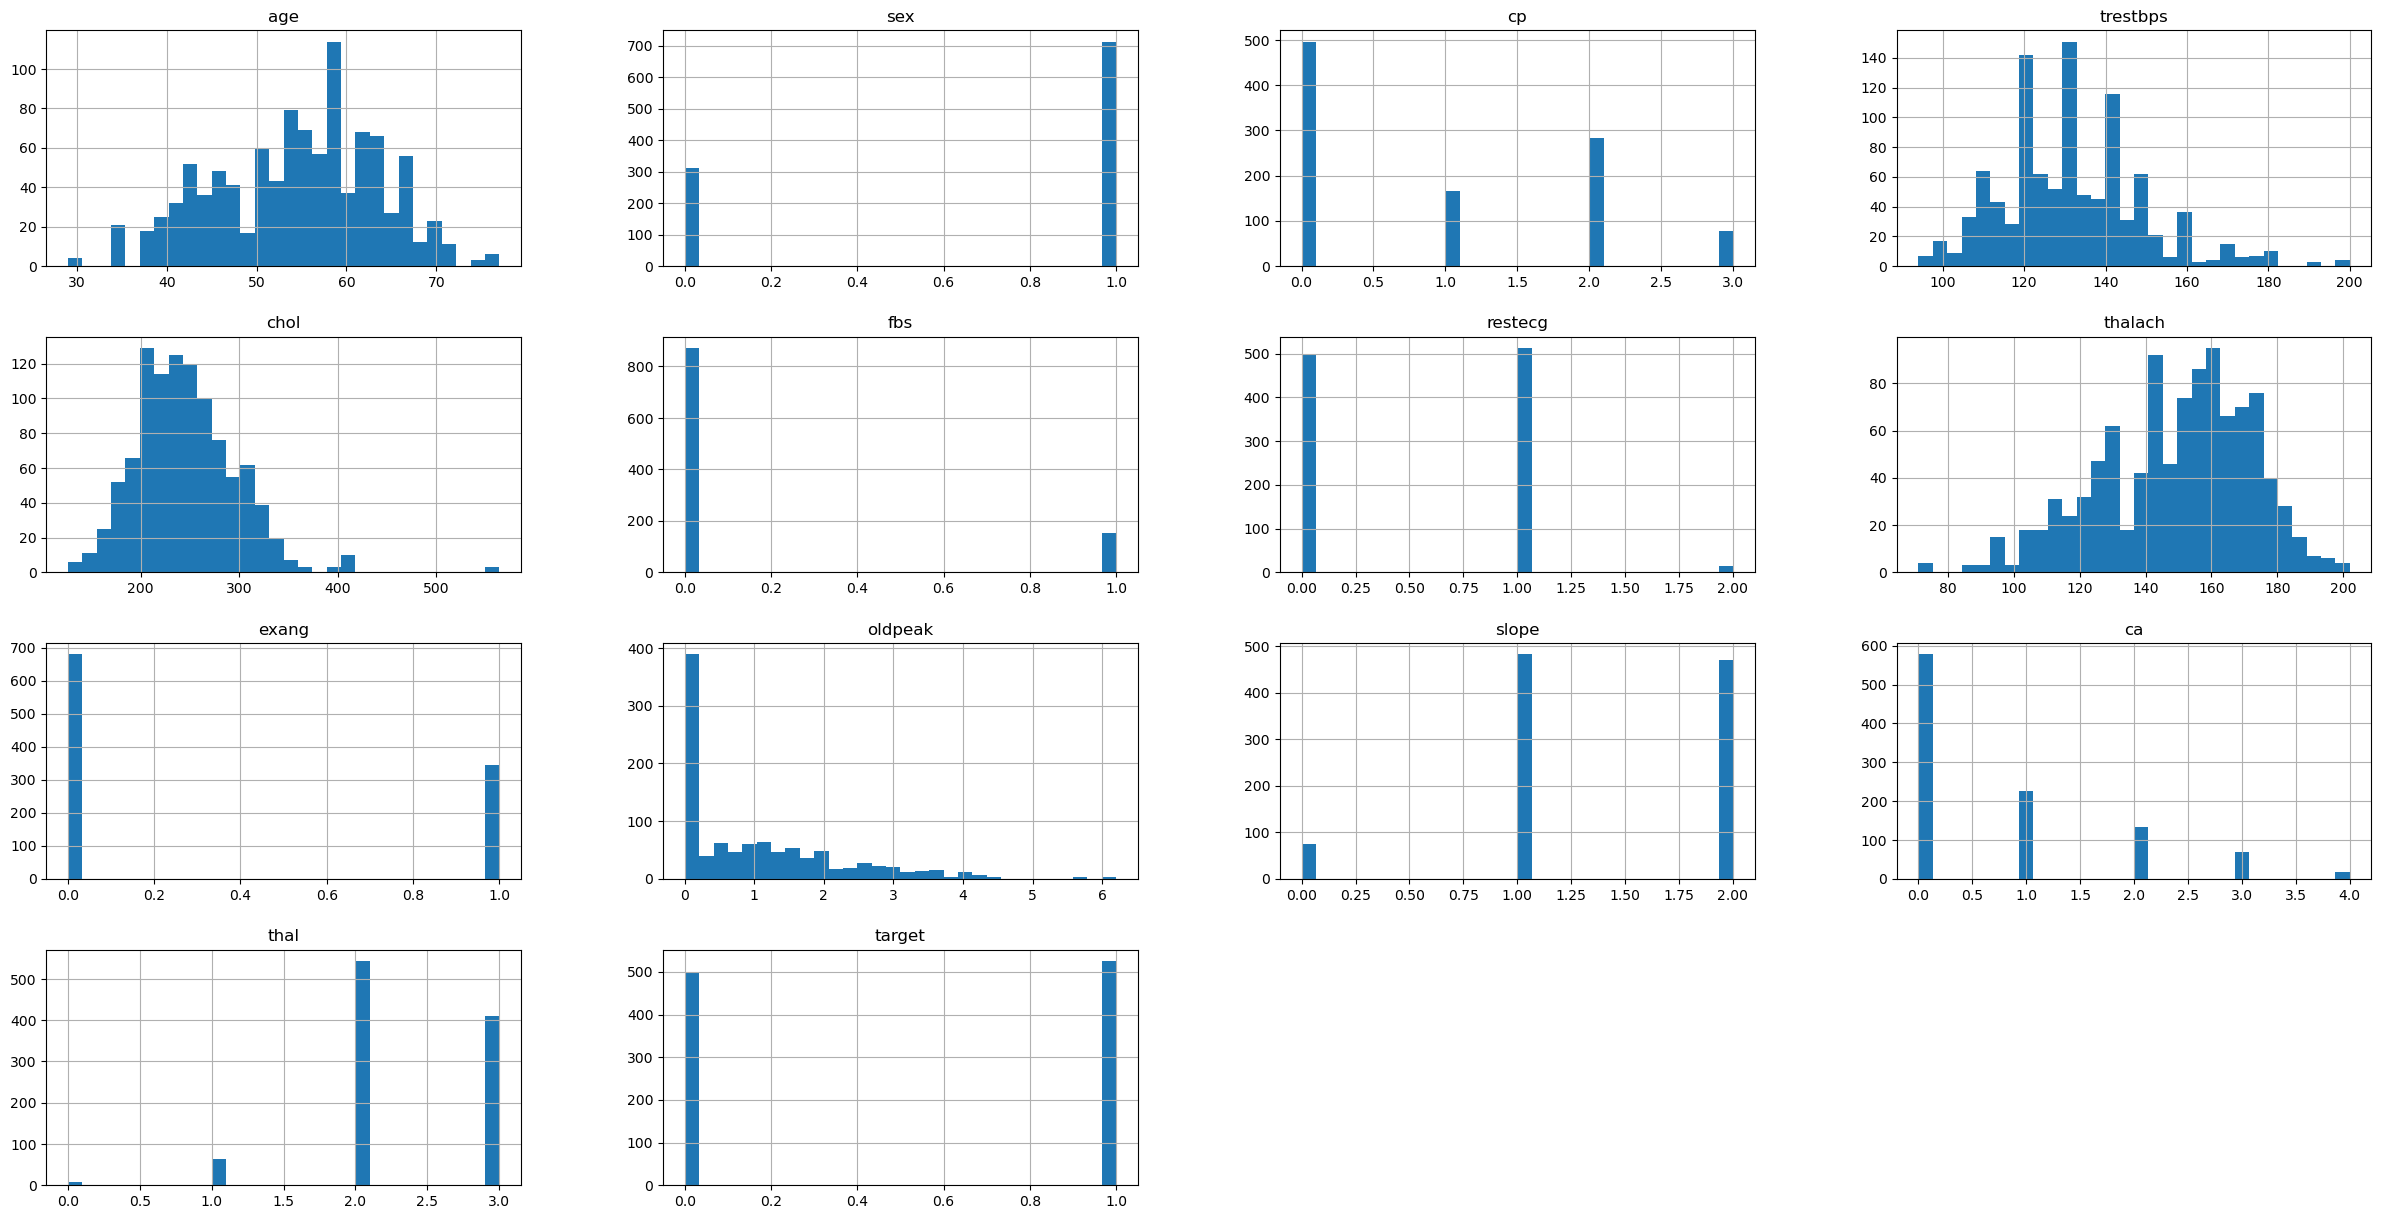

In [69]:
dataframe.hist(bins=30, figsize=(30, 15))

# A continuación, guarda la imagen en un archivo con un nombre específico y formato (por ejemplo, PNG).
plt.savefig('histograma.png')

# Finalmente, muestra la imagen en la pantalla (opcional).
plt.show()

<span style="color:#FF5733; font-size:22px; font-weight:bold">Variable Selection and Extraction</span>


In [35]:
#Selección de variables según el análisis de correlación
dataframe=dataframe[['cp', 'thalach', 'slope', 'oldpeak', 'exang','ca','target']]
print(dataframe.shape)
dataframe.head(10)

(1025, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
0,0,168,2,1.0,0,2,0
1,0,155,0,3.1,1,0,0
2,0,125,0,2.6,1,0,0
3,0,161,2,0.0,0,1,0
4,0,106,1,1.9,0,3,0
5,0,122,1,1.0,0,0,1
6,0,140,0,4.4,0,3,0
7,0,145,1,0.8,1,1,0
8,0,144,2,0.8,0,0,0
9,0,116,1,3.2,1,2,0


<span style="color:#FF5733; font-size:22px; font-weight:bold">Outlier Analysis and Removal</span>


In [36]:
from sklearn import preprocessing
data_scaled_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_scaled_minmax = data_scaled_minmax.fit_transform(dataframe)
dataframe_scaled_minmax = pd.DataFrame(data=data_scaled_minmax,columns=dataframe.columns)
print(dataframe_scaled_minmax.shape)
dataframe_scaled_minmax.head(10)

(1025, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
0,0.0,0.740458,1.0,0.161290,0.0,0.50,0.0
1,0.0,0.641221,0.0,0.500000,1.0,0.00,0.0
2,0.0,0.412214,0.0,0.419355,1.0,0.00,0.0
3,0.0,0.687023,1.0,0.000000,0.0,0.25,0.0
4,0.0,0.267176,0.5,0.306452,0.0,0.75,0.0
5,0.0,0.389313,0.5,0.161290,0.0,0.00,1.0
6,0.0,0.526718,0.0,0.709677,0.0,0.75,0.0
7,0.0,0.564885,0.5,0.129032,1.0,0.25,0.0
8,0.0,0.557252,1.0,0.129032,0.0,0.00,0.0
9,0.0,0.343511,0.5,0.516129,1.0,0.50,0.0


In [37]:
import plotly.graph_objs as go
import numpy as np
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# Generate example data (replace this with your own data)
#np.random.seed(0)
#data = np.random.rand(100, 3)
#np.random.rand(200)

# Select the three columns you want to convert
selected_columns = dataframe_scaled_minmax[['cp', 'thalach', 'slope']]

# Convert the selected columns to a numpy.ndarray
data = selected_columns.to_numpy()

# Define a threshold (Euclidean distance) to identify outliers (adjust as needed)
threshold = 1.2

# Compute the Euclidean distance from the origin (center) for each data point
distances = np.linalg.norm(data, axis=1)

# Identify the indices of outliers
outliers_indices = np.where(distances > threshold)[0]

# Separate the data into two groups: normal points and outliers
normal_points = data[distances <= threshold]
outliers = data[outliers_indices]

# Create an interactive 3D figure
fig = go.Figure()

# Plot the normal data points (inside the sphere)
fig.add_trace(go.Scatter3d(
    x=normal_points[:, 0],
    y=normal_points[:, 1],
    z=normal_points[:, 2],
    mode='markers',
    marker={'color':'blue', 'size':4},
    name='Normal Points'
))

# Plot the outliers (outside the sphere)
fig.add_trace(go.Scatter3d(
    x=outliers[:, 0],
    y=outliers[:, 1],
    z=outliers[:, 2],
    mode='markers',
    marker={'color':'red', 'size':4},
    name='Outliers'
))

# Create a sphere that excludes the outliers
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = threshold * np.outer(np.cos(u), np.sin(v))
y = threshold * np.outer(np.sin(u), np.sin(v))
z = threshold * np.outer(np.ones_like(u), np.cos(v))

fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='greens', opacity=0.3, showscale=False, name='Threshold Sphere'))

# Configure the figure layout
fig.update_layout(
    scene={
        'xaxis_title':'X: cp', # X AXIS
        'yaxis_title':'Y: thalach', # Y AXIS
        'zaxis_title':'Z: slope' # Z AXIS
    },
    scene_camera={
        'center':{'x':0, 'y':0, 'z':0},
        'eye':{'x':1.25, 'y':1.25, 'z':1.25}
    }
)

# Show the interactive figure
fig.show()

# Calculate the distance to the origin for each sample
dataframe_scaled_minmax['DIST'] = np.sqrt(dataframe_scaled_minmax['cp']**2 + dataframe_scaled_minmax['thalach']**2 + dataframe_scaled_minmax['slope']**2)
# Filter the DataFrame to get only the samples inside the sphere
filtered_df = dataframe_scaled_minmax[dataframe_scaled_minmax['DIST'] <= threshold]
print(filtered_df.shape)
filtered_df.head(20)


(592, 8)


,cp,thalach,slope,oldpeak,exang,ca,target,DIST
1,0.000000,0.641221,0.0,0.500000,1.0,0.00,0.0,0.641221
2,0.000000,0.412214,0.0,0.419355,1.0,0.00,0.0,0.412214
4,0.000000,0.267176,0.5,0.306452,0.0,0.75,0.0,0.566906
5,0.000000,0.389313,0.5,0.161290,0.0,0.00,1.0,0.633691
6,0.000000,0.526718,0.0,0.709677,0.0,0.75,0.0,0.526718
7,0.000000,0.564885,0.5,0.129032,1.0,0.25,0.0,0.754384
8,0.000000,0.557252,1.0,0.129032,0.0,0.00,0.0,1.144784
9,0.000000,0.343511,0.5,0.516129,1.0,0.50,0.0,0.606630
10,0.000000,0.412214,0.5,0.258065,0.0,0.00,1.0,0.648012
11,0.000000,0.496183,0.5,0.483871,1.0,0.00,0.0,0.704413


<span style="color:#FF5733; font-size:22px; font-weight:bold">Data Segmentation: </span>

In [39]:
# Calcular la distancia al origen para cada muestra
dataframe_scaled_minmax['DIST'] = np.sqrt(dataframe_scaled_minmax['cp']**2 + dataframe_scaled_minmax['thalach']**2 + dataframe_scaled_minmax['slope']**2)
# Filtrar el DataFrame para obtener solo las muestras dentro de la esfera
df_filtrado = dataframe_scaled_minmax[dataframe_scaled_minmax['DIST'] <= threshold]
df_filtrado = df_filtrado.drop(['DIST'], axis=1)
#Guardar el dataset
df_filtrado.to_csv("DatasetNormalizadoyFiltrado.csv", sep=";",index = False)
print(df_filtrado.shape)
df_filtrado.head(20)

(592, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
1,0.000000,0.641221,0.0,0.500000,1.0,0.00,0.0
2,0.000000,0.412214,0.0,0.419355,1.0,0.00,0.0
4,0.000000,0.267176,0.5,0.306452,0.0,0.75,0.0
5,0.000000,0.389313,0.5,0.161290,0.0,0.00,1.0
6,0.000000,0.526718,0.0,0.709677,0.0,0.75,0.0
7,0.000000,0.564885,0.5,0.129032,1.0,0.25,0.0
8,0.000000,0.557252,1.0,0.129032,0.0,0.00,0.0
9,0.000000,0.343511,0.5,0.516129,1.0,0.50,0.0
10,0.000000,0.412214,0.5,0.258065,0.0,0.00,1.0
11,0.000000,0.496183,0.5,0.483871,1.0,0.00,0.0


<span style="color:#FF5733; font-size:22px; font-weight:bold">Conclusions</span>


Based on the exploratory analysis performed on the Heart Disease dataset, it was determined that:
- The minimum age is 29, the mean age is 54.434146, and the maximum age is 77. Regarding cholesterol, the minimum amount is 126.00000 and the maximum amount is 564.00000.
- According to the frequency plot, it can be observed that there is a higher presence of sick patients (526) than healthy ones (499).
- There is a higher concentration of cholesterol among patients aged 50 to 70, as they have cholesterol levels between 200 and 300. However, a very clear correlation cannot be determined.
- As more patients have been recorded, it can be observed that each one's resting blood pressure varies greatly, with a tendency to increase over time.
- The 3 variables most positively correlated are: **cp** (0.434854), **thalach** (0.422895), **slope** (0.345512)
- The 3 variables most negatively correlated are: **oldpeak** (-0.438441), **exang** (-0.438029), **ca** (-0.382085)


<span style="color:#FF5733; font-size:22px; font-weight:bold">Referencias</span>

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.<br>
- Hurtado Ortiz, R. (2023, October 6). Preparación de datos: análisis exploratorio. GensciNet. https://genscinet.com/analisis-exploratorio/
